# Generalized Quantum Signal Processing (GQSP)

<blockquote style="background:rgba(59,130,246,.08);border-left:6px solid #3b82f6;padding:1rem 1.25rem;margin:.5rem 0;"> <strong>Generalized Quantum Signal Processing (GQSP)</strong> is a quantum algorithmic primitive that extends standard QSP, allowing one to block-encode arbitrary polynomials of unitary operations [<a href="#ref-gqsp">1</a>]. It removes the “realness” and parity restrictions on achievable polynomials that appear in QSP [<a href="#ref-grand">2</a>], and provides a simple recipe for constructing complex polynomials $P$ with $|P|\le 1$ on the unit circle. Moreover, it can be used to implement polynomials with negative powers, i.e., Laurent polynomials, further broadening the class of transformations accessible within this framework. The polynomial transformation is achieved by applying a sequence of arbitrary SU(2) rotations on an auxiliary qubit, rather than rotations in a fixed basis.  The GQSP routine has several applications, such as state preparation and phase function transformations ($e^{iH}\!\to e^{if(H)}$). A notable case is Hamiltonian simulation, where GQSP offers a more direct and flexible route compared to standard QSP.
<br> <ul> 
  <li><strong>Input:</strong> A unitary operator (quantum function) $U$, and a target polynomial transformation $P(\cdot)$ with $|P(x)| \leq 1$ for $\{x \in \mathbb{C} : |x| = 1\}$.  
  </li> 
  <li><strong>Output:</strong> A unitary that block-encodes $P(U)$ using a single-qubit block variable.  
  </li> 
</ul>
</li> </ul> <br> <strong>Complexity:</strong> Applying a polynomial of degree $d$ requires $d$ controlled-$U$ calls and $d$ single-qubit SU(2) rotations.

<hr> <strong>Keywords:</strong> Quantum Signal Processing (QSP), Polynomial transformations, Block-encoding, Hamiltonian simulation, Phase functions. </blockquote>

In this demo we implement a simple instance of the GQSP primitive, preparing a state $\propto \sum_x\cos^3(x)$, by applying the corresponding polynomial on a diagonal unitary matrix. Using the `gqsp` quantum function from the open-library, phase assignment with `phase`, and utility classical function for obtaining the QSP angles, the implementation is done naturally.

***
***

In [1]:
!pip install -qq "classiq[qsp]"

## Example: Preparing $|\psi\rangle \propto \sum_x\cos^3(x)|x\rangle$ state

The idea of the algorithm is to prepare a diagonal unitary $U$, such that $U|x\rangle = e^{ix}|x\rangle$. Then, if we apply a polynomial $P(x)$ such that $P(e^{ix})=\cos^3(x)$, then we get $P(U)|x\rangle = \cos^3(x)$.

First, we write  our function as a Laurent polynomial in $e^{ix}$:
$$
\cos^3(x) = \frac{1}{8}(e^{ix}+e^{-ix})^3 =\frac{1}{8}(e^{3 ix}+3e^{ix}+3e^{-ix}+e^{-3ix}).
$$
Thus, the polynomial we are looking at is $P(z) = \frac{1}{8}(z^{-3}+3z^{-1}+3z+z^3)$. First, we find the GQSP angles, by calling the `gqsp_phases` function:

In [2]:
import numpy as np

from classiq.applications.qsp import gqsp_phases

laurent_coeffs = 1 / 8 * np.array([1, 0, 3, 0, 3, 0, 1])
gqsp_phases = gqsp_phases(laurent_coeffs)

The GQSP phases correspond to a polynomial with positive powers, $\tilde{P}(z) = \frac{1}{8}(1+3z^{2}+3z^4+z^6)$, however, the GQSP quantum function can shift it with a negative power, $P(z) = z^{-m} \tilde{P}(z)$,  with $m=3$.

In [3]:
negative_power = 3

Next, we define the unitary we would like to operate on, $U|x\rangle = e^{ix}|x\rangle$. It is simply defined by calling the `phase` function:

In [4]:
import numpy as np

from classiq import *


@qfunc
def u_func(x: QNum):
    phase(2 * np.pi * x)

Next, we define a model that prepares the desired state. This is done by initializing 
$|0\rangle\rightarrow \frac{1}{2^{N/2}}\sum^{2^N-1}_{x=0}|x\rangle$, and then applying $P(U)$ via `gqsp`.

In [5]:
NUM_QUBITS = 7


@qfunc
def main(x: Output[QNum[NUM_QUBITS, UNSIGNED, NUM_QUBITS]], ind: Output[QBit]):
    allocate(ind)
    allocate(x)
    hadamard_transform(x)
    gqsp(
        u=lambda: u_func(x), aux=ind, phases=gqsp_phases, negative_power=negative_power
    )


write_qmod(main, "gqsp", symbolic_only=True)

Now we can synthesize and execute the resulting quantum program

In [6]:
qprog = synthesize(main)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/32gmqPWiRcA3Kq4XV3hX8LlU8sX


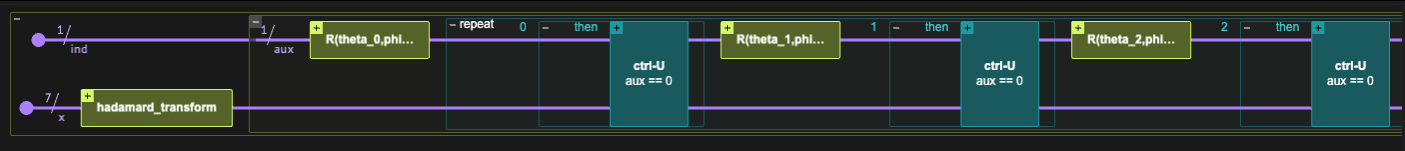

In [7]:
NUM_SHOTS = 1e5
with ExecutionSession(qprog, ExecutionPreferences(num_shots=NUM_SHOTS)) as es:
    result = es.sample()

We can verify the resulting distribution against the expected one (recall that we need to post-select on the block variable `ind`==0) 

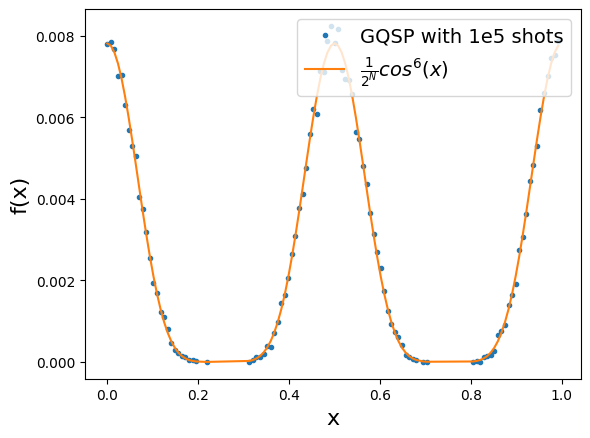

In [8]:
import matplotlib.pyplot as plt

df = result.dataframe
df_post_selected = df[df.ind == 0].sort_values("x")
x, prob = df_post_selected.x, df_post_selected.probability
plt.plot(x, prob, ".", label=f"GQSP with 1e{int(np.log10(NUM_SHOTS))} shots")
plt.plot(
    x,
    (1 / 2 ** (NUM_QUBITS / 2) * np.cos(2 * np.pi * x) ** 3) ** 2,
    "-",
    label=r"$\frac{1}{2^N}cos^6(x)$",
)
plt.xlabel("x", fontsize=16)
plt.ylabel("f(x)", fontsize=16)
plt.legend(loc="upper right", fontsize=14)

<h3 id="references">References</h3>
<ol>
     <li id="ref-gqsp">
    Motlagh, D, and Nathan W. Generalized quantum signal processing. PRX Quantum 5 020368 (2024). 
    <!-- External links -->
    &nbsp;- &nbsp;
    <a href="https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.5.020368" target="_blank" rel="noopener noreferrer">DOI&#8599;</a>
  <li id="ref-grand">
    Martyn JM, Rossi ZM, Tan AK, Chuang IL. Grand unification of quantum algorithms. PRX Quantum 2, 040203. (2021).
    <!-- External links -->
    &nbsp;- &nbsp;
    <a href="https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040203" target="_blank" rel="noopener noreferrer">DOI &#8599;</a>
</ol>